# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Project Overview

This is the capstone project for the Udacity Data Science Nanodegree. The purpose of this assignment is to gain exposure to tools used to manipulate and build machine learning algorithms on large data sets. Specifically, here we use Spark Dataframes and the machine learning API Spark ML.

**Problem Statement**

In this assignment we are working with data from a digital music streaming service. The aim of the project is to be able to predict the 'churn' or probability a user of the service will leave so that we can decide whether to offer the user incentives to stay.
The data set contains a number of variables for each user about their status and previous interactions with the platform. Using machine learning algorithms we aim to accurately predict whether a user is likely to cancel their service.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import  StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

Check each column for missing or null values.

In [68]:
for cols in df.columns:
    null_values_count = df.where(df[cols].isNull()).count() 
    blank_string_count = df.where(df[cols] == "").count()
    print('column {} has {} null values and {} blank strings.'.format(cols, null_values_count, blank_string_count))

column artist has 58392 null values and 0 blank strings.
column auth has 0 null values and 0 blank strings.
column firstName has 8346 null values and 0 blank strings.
column gender has 8346 null values and 0 blank strings.
column itemInSession has 0 null values and 0 blank strings.
column lastName has 8346 null values and 0 blank strings.
column length has 58392 null values and 0 blank strings.
column level has 0 null values and 0 blank strings.
column location has 8346 null values and 0 blank strings.
column method has 0 null values and 0 blank strings.
column page has 0 null values and 0 blank strings.
column registration has 8346 null values and 0 blank strings.
column sessionId has 0 null values and 0 blank strings.
column song has 58392 null values and 0 blank strings.
column status has 0 null values and 0 blank strings.
column ts has 0 null values and 0 blank strings.
column userAgent has 8346 null values and 0 blank strings.
column userId has 0 null values and 8346 blank strings

Remove rows where either the userId or the sessionId contains a null value or blank strings.

In [69]:
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df = df.where(df['userId'] != "")

In [70]:
for cols in df.columns:
    null_values_count = df.where(df[cols].isNull()).count() 
    blank_string_count = df.where(df[cols]=="").count()
    print('column {} has {} null values and {} blank strings.'.format(cols, null_values_count, blank_string_count))

column artist has 50046 null values and 0 blank strings.
column auth has 0 null values and 0 blank strings.
column firstName has 0 null values and 0 blank strings.
column gender has 0 null values and 0 blank strings.
column itemInSession has 0 null values and 0 blank strings.
column lastName has 0 null values and 0 blank strings.
column length has 50046 null values and 0 blank strings.
column level has 0 null values and 0 blank strings.
column location has 0 null values and 0 blank strings.
column method has 0 null values and 0 blank strings.
column page has 0 null values and 0 blank strings.
column registration has 0 null values and 0 blank strings.
column sessionId has 0 null values and 0 blank strings.
column song has 50046 null values and 0 blank strings.
column status has 0 null values and 0 blank strings.
column ts has 0 null values and 0 blank strings.
column userAgent has 0 null values and 0 blank strings.
column userId has 0 null values and 0 blank strings.


Check why we have null values in the artists column. First look at all the unique events pages that have null values then without null values.

In [71]:
df.where(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [72]:
df.where(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



All events except page 'NextSong' has null values for the 'Authors' sites. Seems like it is okay to keep these rows.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

To get a better picture of what is contained in the dataset, we'll look at the range of values in each column.

In [73]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's look at the categorical columns.

In [74]:
category_columns = ['artist', 'auth', 'gender', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']
for cols in category_columns:
    
    unique_count = df.select(df[cols]).dropDuplicates().count()
    
    print('Column {} has {} unique values, for example:'.format(cols, unique_count))
    print(df.select(df[cols]).dropDuplicates().show())

Column artist has 17656 unique values, for example:
+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows

None
Column auth has 2 unique values, for example:
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

None
Column gender has 2 unique values, for example:
+------+
|gender|
+------+
|     F|
|     M|
+------+

None
Column level has 2 unique values, for example:
+-----+
|level|
+-----+
| free|
| paid|
+-----+

None
Column location has 114 unique v

Now we will explore the numerical columns.

In [75]:
numerical_columns = ['itemInSession', 'length', 'status', 'ts']

df.select(numerical_columns).describe().show()

+-------+------------------+-----------------+------------------+--------------------+
|summary|     itemInSession|           length|            status|                  ts|
+-------+------------------+-----------------+------------------+--------------------+
|  count|            278154|           228108|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|               200|       1538352117000|
|    max|              1321|       3024.66567|               404|       1543799476000|
+-------+------------------+-----------------+------------------+--------------------+



Next create a column for churn.

In [76]:
churned_users = df.where(df['page'] == "Cancellation Confirmation").select("userId").dropDuplicates()
churned_users_list = [(row['userId']) for row in churned_users.collect()]
churned_df = df.withColumn("churned", df['userId'].isin(churned_users_list))

This next section performs explortory data analysis to answer the following questions:
- Do males or females churn more often?
- Do paid user churn more than free users?
- Does location affect users churn rates?
- Does the time a user has been active with the product affect churn rate?
- Does the use page events affect the churn rate?

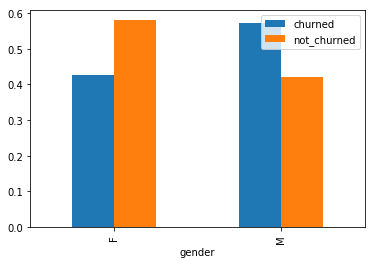

In [77]:
# Visualise the percent of males and females that churn.

num_churned = churned_df.where(churned_df['churned'] == 1).count()
num_not_churned = churned_df.where(churned_df['churned'] == 0).count()

tmp_churned_df = churned_df.where(churned_df['churned'] == 1).groupby(['gender']).count()
tmp_churned_df = tmp_churned_df.withColumn('churned', tmp_churned_df['count'] / num_churned).sort('gender')

tmp_not_churned_df = churned_df.where(churned_df['churned'] == 0).groupby(['gender']).count()
tmp_not_churned_df = tmp_not_churned_df.withColumn('not_churned', tmp_not_churned_df['count'] / num_not_churned).sort('gender')

tmp_df = tmp_churned_df.join(tmp_not_churned_df, 'gender', 'outer').drop('count').fillna(0).toPandas()

tmp_df.plot.bar('gender')

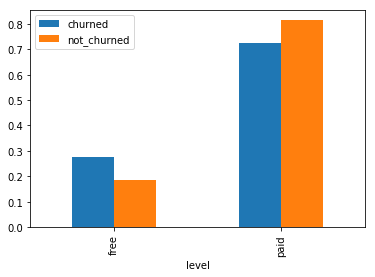

In [78]:
# Visualise the percent of free vs page users that churn. 
num_churned = churned_df.where(churned_df['churned'] == 1).count()
num_not_churned = churned_df.where(churned_df['churned'] == 0).count()

tmp_churned_df = churned_df.where(churned_df['churned'] == 1).groupby(['level']).count()
tmp_churned_df = tmp_churned_df.withColumn('churned', tmp_churned_df['count'] / num_churned).sort('level')

tmp_not_churned_df = churned_df.where(churned_df['churned'] == 0).groupby(['level']).count()
tmp_not_churned_df = tmp_not_churned_df.withColumn('not_churned', tmp_not_churned_df['count'] / num_not_churned).sort('level')

tmp_df = tmp_churned_df.join(tmp_not_churned_df, 'level', 'outer').drop('count').fillna(0).toPandas()

tmp_df.plot.bar('level')

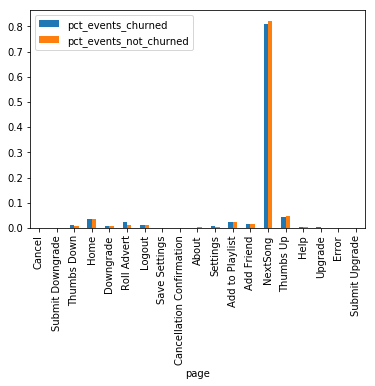

In [79]:
# Visualise the percent of page events for churned users vs. non-churned users.

num_churned = churned_df.where(churned_df['churned'] == 1).count()
num_not_churned = churned_df.where(churned_df['churned'] == 0).count()

tmp_churned_df = churned_df.where(churned_df['churned'] == 1).groupby(['page']).count()
tmp_churned_df = tmp_churned_df.withColumn('pct_events_churned', tmp_churned_df['count'] / num_churned).sort('page')

tmp_not_churned_df = churned_df.where(churned_df['churned'] == 0).groupby(['page']).count()
tmp_not_churned_df = tmp_not_churned_df.withColumn('pct_events_not_churned', tmp_not_churned_df['count'] / num_not_churned).sort('page')

tmp_df = tmp_churned_df.join(tmp_not_churned_df, 'page', 'outer').drop('count').fillna(0).toPandas()

tmp_df.plot.bar('page')

Plot again, this time excluding page event 'NextSong' as it makes up the majority of events and makes it difficult to see the differences between the other events.

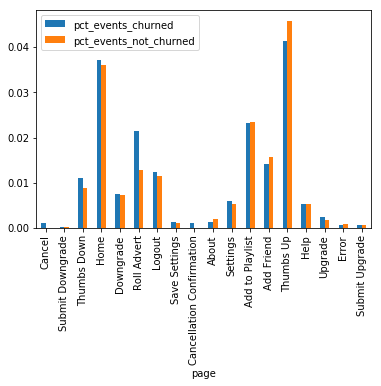

In [80]:
tmp_df = tmp_df[tmp_df['page']!='NextSong']
tmp_df.plot.bar('page')

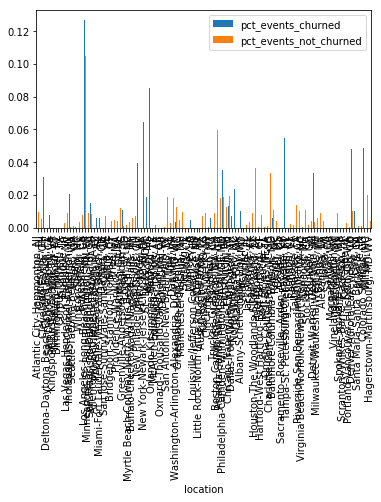

In [81]:
# Visualise the percent churned users vs. non-churned for users by location.

num_churned = churned_df.where(churned_df['churned'] == 1).count()
num_not_churned = churned_df.where(churned_df['churned'] == 0).count()

tmp_churned_df = churned_df.where(churned_df['churned'] == 1).groupby(['location']).count()
tmp_churned_df = tmp_churned_df.withColumn('pct_events_churned', tmp_churned_df['count'] / num_churned).sort('location')

tmp_not_churned_df = churned_df.where(churned_df['churned'] == 0).groupby(['location']).count()
tmp_not_churned_df = tmp_not_churned_df.withColumn('pct_events_not_churned', tmp_not_churned_df['count'] / num_not_churned).sort('location')

tmp_df = tmp_churned_df.join(tmp_not_churned_df, 'location', 'outer').drop('count').fillna(0).toPandas()

tmp_df.plot.bar('location')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.


Label: Churn is defined by the page is 'cancellation confirmation'. 

Feature 1: Measured as the time since registration in days.
Feature 2: Measured as the user's gender.
Feature 3: Meausred as whether the user was most recently paying or using the product for free.
Feature 4: Measured as the number of sessions
Feature 5: Measured as the number of songs listened to.
Feature 6: Measured as the average time per session. 
Feature 7: Measured by the number of 'Thumbs Up' pages.
Feature 8: Measured by the number of 'Thumbs Down' pages.
Feature 9: Measured by the number of 'Add to Playlist' pages. 
Feature 10: Measured by the number of 'Add Friend' pages.
Feature 11: Measured by the number of 'NextSong' pages.

In [82]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [83]:
# User churned or not.
#churned_users = df.where(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
#churned_users_list = [(row['userId']) for row in churned_users.collect()]
#df = df.withColumn("churned", df['userId'].isin(churned_users_list))

churned_users = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churned', churned_users('page'))

label = df.select('userId', 'churned').dropDuplicates().withColumnRenamed('churned', 'label')
print((label.count(), len(label.columns)))

(277, 2)


In [84]:
# Time since user registered.
feature1 = df.select('userId','registration','ts').withColumn('lifetime',(df['ts'] - df['registration'])).groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId', 'lifetime')
print((feature1.count(), len(feature1.columns)))

(225, 2)


In [85]:
# Gender
feature2 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
print((feature2.count(), len(feature2.columns)))

(225, 2)


In [86]:
levels_converter = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
feature3 = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level']).withColumn('level', levels_converter('level').cast(IntegerType()))
print((feature3.count(), len(feature3.columns)))

(225, 2)


In [87]:
# Number of sessions
feature4 = df.select('UserId', 'sessionId').groupBy('userId').count().withColumnRenamed('count', 'number_sessions')
print((feature4.count(), len(feature4.columns)))

(225, 2)


In [88]:
# Number of songs listened to.
feature5 = df.select('userId','song').groupBy('userId').count().withColumnRenamed('count', 'number_songs')
print((feature5.count(), len(feature5.columns)))

(225, 2)


In [89]:
# Average time per session.
feature6 = df.groupby(['userId']).agg({'length':'avg'}).withColumnRenamed('avg(length)', 'average_time_per_session')
print((feature6.count(), len(feature6.columns)))

(225, 2)


In [90]:
# Number of pages equal to 'thumbs-up'.
feature7 = df.select('userId','page').where(df['page'] == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'number_thumbs_up') 
print((feature7.count(), len(feature7.columns)))

(220, 2)


In [91]:
# Number of pages equal to 'thumbs-down'
feature8 = df.select('userId','page').where(df['page'] == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'number_thumbs_down')
print((feature8.count(), len(feature8.columns)))

(203, 2)


In [92]:
# Number of 'Add to Playlist' pages. 
feature9 = df.select('userId','page').where(df['page'] == 'Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'number_add_to_playlist')
print((feature9.count(), len(feature9.columns)))

(215, 2)


In [93]:
# Number of 'Add Friend' pages. 
feature10 = df.select('userId', 'page').where(df['page'] == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'number_add_friend') 
print((feature10.count(), len(feature10.columns)))

(206, 2)


In [94]:
# number of 'NextSong' pages.
feature11 =  df.select('userId', 'page').where(df['page'] == 'NextSong').groupby('userId').count().withColumnRenamed('count', 'number_next_songs')
print((feature11.count(), len(feature11.columns)))

(225, 2)


In [95]:
feature_data = label.join(feature1,'userId','outer') \
    .join(feature2, 'userId', 'outer') \
    .join(feature3,'userId','outer') \
    .join(feature4,'userId','outer') \
    .join(feature5,'userId','outer') \
    .join(feature6,'userId','outer') \
    .join(feature7,'userId','outer') \
    .join(feature8,'userId','outer') \
    .join(feature9,'userId','outer') \
    .join(feature10,'userId','outer') \
    .join(feature11,'userId','outer') \
    .drop('userId') \
    .fillna(0)

feature_data.show(3)

+-----+----------+------+-----+---------------+------------+------------------------+----------------+------------------+----------------------+-----------------+-----------------+
|label|  lifetime|gender|level|number_sessions|number_songs|average_time_per_session|number_thumbs_up|number_thumbs_down|number_add_to_playlist|number_add_friend|number_next_songs|
+-----+----------+------+-----+---------------+------------+------------------------+----------------+------------------+----------------------+-----------------+-----------------+
|    0|4807612000|     0|    0|            381|         381|        243.421444909091|              17|                 5|                     7|                4|              275|
|    0|6054448000|     1|    1|            474|         474|      242.91699209302305|              21|                 6|                     8|                4|              387|
|    1|6161779000|     1|    0|             11|          11|      261.13913750000006|          

In [96]:
print((feature_data.count(), len(feature_data.columns)))

(277, 12)


In [97]:
feature_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- lifetime: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- number_sessions: long (nullable = true)
 |-- number_songs: long (nullable = true)
 |-- average_time_per_session: double (nullable = false)
 |-- number_thumbs_up: long (nullable = true)
 |-- number_thumbs_down: long (nullable = true)
 |-- number_add_to_playlist: long (nullable = true)
 |-- number_add_friend: long (nullable = true)
 |-- number_next_songs: long (nullable = true)



In [98]:
# Save the feature data.
file_path = 'clean_data2.csv'
feature_data.write.save(file_path, format = "csv", header = True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
# Load in the feature data.
file_path = 'clean_data2.csv'
feature_data = spark.read.csv(file_path, header=True)
feature_data.persist()

DataFrame[label: string, lifetime: string, gender: string, level: string, number_sessions: string, number_songs: string, average_time_per_session: string, number_thumbs_up: string, number_thumbs_down: string, number_add_to_playlist: string, number_add_friend: string, number_next_songs: string]

In [4]:
feature_data.printSchema()

root
 |-- label: string (nullable = true)
 |-- lifetime: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- number_sessions: string (nullable = true)
 |-- number_songs: string (nullable = true)
 |-- average_time_per_session: string (nullable = true)
 |-- number_thumbs_up: string (nullable = true)
 |-- number_thumbs_down: string (nullable = true)
 |-- number_add_to_playlist: string (nullable = true)
 |-- number_add_friend: string (nullable = true)
 |-- number_next_songs: string (nullable = true)



In [5]:
# Ensure all features are numerics.
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

columns = ['label', 'lifetime',
 'gender',
 'level',
 'number_sessions',
 'number_songs',
 'average_time_per_session',
 'number_thumbs_up',
 'number_thumbs_down',
 'number_add_to_playlist',
 'number_add_friend',
 'number_next_songs']

feature_data = convertColumn(feature_data, columns, FloatType())    
    
feature_data.printSchema()

root
 |-- label: float (nullable = true)
 |-- lifetime: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- level: float (nullable = true)
 |-- number_sessions: float (nullable = true)
 |-- number_songs: float (nullable = true)
 |-- average_time_per_session: float (nullable = true)
 |-- number_thumbs_up: float (nullable = true)
 |-- number_thumbs_down: float (nullable = true)
 |-- number_add_to_playlist: float (nullable = true)
 |-- number_add_friend: float (nullable = true)
 |-- number_next_songs: float (nullable = true)



In [6]:
# Vectorize the feature data.
feature_columns = ['lifetime',
 'gender',
 'level',
 'number_sessions',
 'number_songs',
 'average_time_per_session',
 'number_thumbs_up',
 'number_thumbs_down',
 'number_add_to_playlist',
 'number_add_friend',
 'number_next_songs']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_data = assembler.transform(feature_data)

In [7]:
# Standardise features.
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features', withStd = True)
scalerModel = scaler.fit(feature_data)
feature_data = scalerModel.transform(feature_data)

In [8]:
# Split feature data into train, test and validate datasets.
train_data, test_data = feature_data.randomSplit([0.6, 0.4], seed=1234)

# Evaluation Metrics

In [9]:
def evaluate_model(prediction, classifier_name):
    
    evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'label')
    
    evaluation_metrics = {}
    evaluation_metrics['Classifier'] = classifier_name
    evaluation_metrics['F1 Score'] = round(evaluator.evaluate(prediction, {evaluator.metricName: 'f1'}), 3)
    evaluation_metrics['Accuracy'] = round(evaluator.evaluate(prediction, {evaluator.metricName: 'accuracy'}), 3)
    evaluation_metrics['Precision'] = round(evaluator.evaluate(prediction, {evaluator.metricName: 'weightedPrecision'}), 3)
    evaluation_metrics['Recall'] = round(evaluator.evaluate(prediction, {evaluator.metricName: 'weightedRecall'}), 3)
    
    metrics = spark.createDataFrame(pd.DataFrame([evaluation_metrics], columns = evaluation_metrics.keys()))
    
    return metrics

**Naive Classifier**

Baseline Model
- Since the 81% of users in the dataset did not churn, testing a naive model that just predicts all users will not churn would have an accuracy of 81%. 
- This is not a good evaluation metrics as it would have a of false positives and a low precision.
- Therefore, we will use the F1-score as our evaluation metric.
- The F1-score incorporates both the recall and precision in the model.
- Where precision measures the proportion of predicted churned users are actually churned.
- And recall measure the proportion of actual churned users that are correctly predicted. 
- We will use the naive model as our baseline model to assess the performance of other models.

In [10]:
prediction = train_data.select("label").withColumn("prediction", lit(0.0))

naive_metrics = evaluate_model(prediction = prediction, classifier_name='naive')
naive_metrics.show()

+----------+--------+--------+---------+------+
|Classifier|F1 Score|Accuracy|Precision|Recall|
+----------+--------+--------+---------+------+
|     naive|    0.73|   0.814|    0.663| 0.814|
+----------+--------+--------+---------+------+



Next we test several classfiers includeing the Random Forest, Logistic Regression, Decision Tree and Gradient Boosting Tree.

**Decision Tree**

In [18]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features", predictionCol="prediction")

paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 4, 8]) \
    .build()

crossval_dt = CrossValidator(estimator = dt,
                      estimatorParamMaps = paramGrid_dt,
                      evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                      numFolds = 3)

cvModel_dt = crossval_dt.fit(train_data)

prediction_dt = cvModel_dt.transform(test_data)
metrics_dt = evaluate_model(prediction = prediction_dt, classifier_name = 'Decision Tree')

prediction_dt_train = cvModel_dt.transform(train_data)
metrics_dt_train = evaluate_model(prediction = prediction_dt_train, classifier_name = 'Decision Tree')

**Random Forest**

In [19]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

crossval_rf = CrossValidator(estimator = rf,
                      estimatorParamMaps = paramGrid_rf,
                      evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                      numFolds = 3)

cvModel_rf = crossval_rf.fit(train_data)

prediction_rf = cvModel_rf.transform(test_data)

metrics_rf = evaluate_model(prediction = prediction_rf, classifier_name = 'Random Forest')


prediction_rf_train = cvModel_rf.transform(train_data)
metrics_rf_train = evaluate_model(prediction = prediction_rf_train, classifier_name = 'Random Forest')

**Gradient Boosting Tree**

In [20]:
gb = GBTClassifier(labelCol="label", featuresCol="scaled_features")

paramGrid_gb = ParamGridBuilder() \
    .addGrid(gb.maxIter, [5, 10]) \
    .addGrid(gb.maxDepth, [2, 4, 8]) \
    .build()

crossval_gb = CrossValidator(estimator = gb,
                      estimatorParamMaps = paramGrid_gb,
                      evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                      numFolds = 3)

cvModel_gb = crossval_gb.fit(train_data)

# Evaluate the classifier on the test data.
prediction_gb = cvModel_gb.transform(test_data)

metrics_gb = evaluate_model(prediction = prediction_gb, classifier_name = 'Gradient Boosting')

# Evaluate the classifier on the training data.
prediction_gb_train = cvModel_gb.transform(train_data)
metrics_gb_train = evaluate_model(prediction = prediction_gb_train, classifier_name = 'Gradient Boosting')

# Results

**Model Evaluation and Validation**
In this section we will look at the performance of each of the classifiers both on the training set and the test set. We also analyse the feature importance for each of the difference classifiers and dicuss the improvement of the hyperparameter tuning.

**Classifier performance on training data**

In [26]:
aggregate_train = naive_metrics.union(metrics_dt_train)
aggregate_train = aggregate_train.union(metrics_rf_train)
aggregate_train = aggregate_train.union(metrics_gb_train)

aggregate_train.show()

+-----------------+--------+--------+---------+------+
|       Classifier|F1 Score|Accuracy|Precision|Recall|
+-----------------+--------+--------+---------+------+
|            naive|    0.73|   0.814|    0.663| 0.814|
|    Decision Tree|   0.757|   0.826|    0.856| 0.826|
|    Random Forest|    0.86|   0.872|    0.862| 0.872|
|Gradient Boosting|   0.757|   0.826|    0.856| 0.826|
+-----------------+--------+--------+---------+------+



The Random Forest classifier performs best across all measures, it has the highest F1-Score and improves upon the recall and precision of the Naive model significantly.

The Decision Tree and Gradient Boosting Tree also improve on the Naive model. Interestingly the results are exactly the same. There doesn't appear to be an error in my code, so it might be the dataset is not large enough to benefit from the Gradient Boosting?!

**Classifier on the test data**

In [27]:
aggregate = naive_metrics.union(metrics_dt)
aggregate = aggregate.union(metrics_rf)
aggregate = aggregate.union(metrics_gb)

aggregate.show()

+-----------------+--------+--------+---------+------+
|       Classifier|F1 Score|Accuracy|Precision|Recall|
+-----------------+--------+--------+---------+------+
|            naive|    0.73|   0.814|    0.663| 0.814|
|    Decision Tree|   0.724|   0.781|    0.694| 0.781|
|    Random Forest|   0.659|   0.686|    0.634| 0.686|
|Gradient Boosting|   0.724|   0.781|    0.694| 0.781|
+-----------------+--------+--------+---------+------+



The Random Forest classifier performs poorly out-of-sample and has the worst performance measures out of all the models. 

Even the Decision Tree and Gradient Boosting Tree are worse than the naive model. And again the results of the two classifiers are exactly the same, which leads me to believe one is erroroneous.

**Hyperparameter Tuning**

In [28]:
def get_hyperparameters_metrics(cvModel):
    params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

    hyperparameters = pd.DataFrame.from_dict([{cvModel.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, cvModel.avgMetrics)])

    return hyperparameters

In [29]:
hp_gb = get_hyperparameters_metrics(cvModel_gb)
print('Gradient Boosting Tree Hyperparameters')
hp_gb

Gradient Boosting Tree Hyperparameters


,f1,maxDepth,maxIter
0,0.715724,2,5
1,0.694737,4,5
2,0.650318,8,5
3,0.712273,2,10
4,0.670035,4,10
5,0.655879,8,10


Performance declines with the depth of the tree.

In [30]:
hp_dt = get_hyperparameters_metrics(cvModel_dt)
print('Decision Tree Hyperparameters')
hp_dt

Decision Tree Hyperparameters


,f1,impurity,maxDepth
0,0.725999,entropy,2
1,0.717740,entropy,4
2,0.686851,entropy,8
3,0.722648,gini,2
4,0.702966,gini,4
5,0.650312,gini,8


In [31]:
hp_rf = get_hyperparameters_metrics(cvModel_rf)
print('Random Forest Hyperparameters')
hp_rf

Random Forest Hyperparameters


,f1,maxDepth,numTrees
0,0.738076,5,5
1,0.708777,10,5
2,0.708777,20,5
3,0.702985,5,10
4,0.693619,10,10
5,0.693619,20,10


Lower maxDepth performs better than higer maxDepth indicating that there aren't many useful features in the dataset to divide the data on.

Fewer trees performs better than more trees, which seems counter intuitive. Perhpas when the dataset is larger, more trees would result in better performance.

**Feature Importance**

In [32]:
def plot_feature_importance(feature_importances, feature_columns, classifier_name):
    x_values = list(range(len(feature_importances)))

    plt.bar(x_values, feature_importances, orientation = 'vertical')
    plt.xticks(x_values, feature_columns, rotation=90)
    plt.ylabel('Feature Importances')
    plt.xlabel('Feature')
    plt.title('{} - Feature Importance'.format(classifier_name))

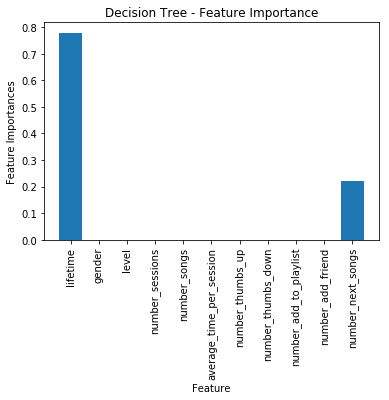

In [33]:
best_dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features", impurity='entropy', maxDepth=2)

best_trained_dt = best_dt.fit(train_data)

feature_importances = best_trained_dt.featureImportances

classifier_name = 'Decision Tree'
plot_feature_importance(feature_importances, feature_columns, classifier_name)

My interpretation of this figure is that the Decision Tree only has two nodes based on 'lifetime' (how long the user has been on the platform and 'number_next_songs'. This would indicate that these two features are all that is needed by the classifier to predict churn.

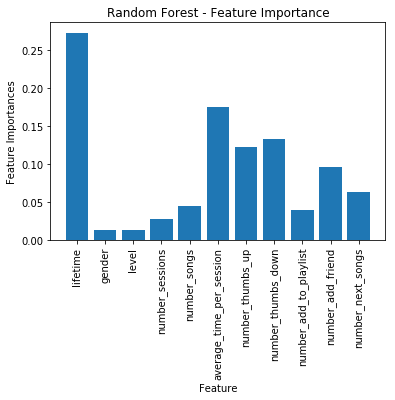

In [34]:
best_rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10, maxDepth=5)

best_trained_rf = best_rf.fit(train_data)

feature_importances = best_trained_rf.featureImportances

classifier_name = 'Random Forest'
plot_feature_importance(feature_importances, feature_columns, classifier_name)

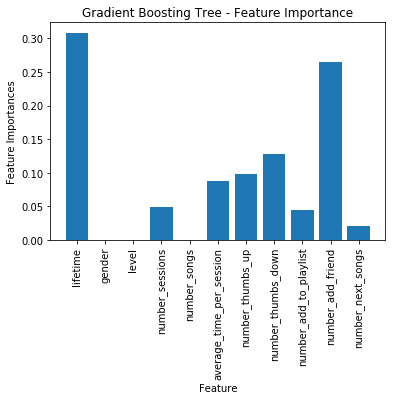

In [35]:
best_gb = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10, maxDepth=2)
best_trained_gb = best_gb.fit(train_data)

feature_importances = best_trained_gb.featureImportances

classifier_name = 'Gradient Boosting Tree'
plot_feature_importance(feature_importances, feature_columns, classifier_name)

Both the Random Forest and Gradient Boosting Trees find most features useful in predicting churn.

The time a user has been with the product is consistently the most important feature in the predicting churn.

**Justification**

We tested the performance of three models in this analysis, Decision Trees, Random Forests and Gradient Boosting Trees. The second two are ensemble learning methods and are designed to adjust for the over-fitting of the decision tree.

**Improvements**

An attempt was made to include a number of machine learning classifiers, however model exist and could perform better for this task. An extension of this analysis would be to try Logistic Regression or Support Vector Machines to predict churn.

The hyperparamters used were selected as they are popular parameters that would seem to have the most improvement on the model, however other parameters can be used and more values could be tested when the models are run on larger computing resources with more data.

Another technique to improve the performance of the model is to increase the number of folds within the cross-validation process. On a small data set, 3 folds is reasonable, however on larger data sets this could be increased. This is likely to improve the out-of-sample performance that seems to be an issue on this analysis.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.